## Scale Magnitude Transform for genre/rythmic pattern classification


In [ ]:
%load_ext autoreload
%autoreload 2

import mirdata
import librosa
import helpers
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

## Groove Midi

_Jon Gillick, Adam Roberts, Jesse Engel, Douglas Eck, and David Bamman.
"Learning to Groove with Inverse Sequence Transformations."
International Conference on Machine Learning (ICML), 2019._

The Groove MIDI Dataset (GMD) is composed of 13.6 hours of aligned MIDI and (synthesized) audio of human-performed, tempo-aligned expressive drumming. The dataset contains 1,150 MIDI files and over 22,000 measures of drumming.

It could be used to classify fills or beats. Keep in mind that while fills tend to have a short duration (few seconds), beats tend to be longer. Therefore beats should be segmented in shorter chunks?


In [57]:
groove_dataset = mirdata.initialize("groove_midi")
# groove_dataset.download()
groove_dataset.validate()

100%|██████████| 1150/1150 [00:25<00:00, 45.79it/s] 
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

track.style -> a string style for the performance formatted as “primary/secondary” (e.g. rock/halftime, funk/purdieshuffle). The primary style comes from the Genre List below.

Genre List: afrobeat, afrocuban, blues, country, dance, funk, gospel, highlife, hiphop, jazz, latin, middleeastern, neworleans, pop, punk, reggae, rock, soul

For the following experiment the label will consist of the primary style only.


In [58]:
features = []
labels = []
for _, track in tqdm(groove_dataset.load_tracks().items()):
    if track.beat_type == "fill":
        try:
            y, sr = librosa.load(track.audio_path, sr=8000)
            features.append(helpers.compute_stm(y=y, sr=sr, win_size=256, hop=128, auto_cor_lag_seconds=3)[:60])
            labels.append(track.style.split("/")[0])
        except Exception as e:
            # exception encoutered with invalid audio_path
            print("Error:", e)
            continue

encoded_labels = LabelEncoder().fit_transform(labels)

100%|██████████| 1150/1150 [00:20<00:00, 55.50it/s]

Error: Invalid file: None


Cross-Validation Scores: [0.29230769 0.34108527 0.40310078 0.36434109 0.34883721]
Mean CV Accuracy: 0.3499344066785927


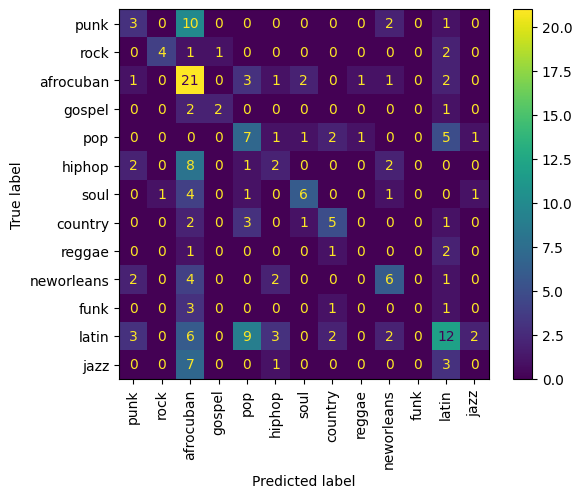

In [59]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, encoded_labels, cv=k_fold, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()

## Ballroom


In [60]:
ballroom_dataset = mirdata.initialize("ballroom")
# ballroom_dataset.download()
ballroom_dataset.validate()

100%|██████████| 698/698 [00:09<00:00, 75.06it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'tracks': {}}, {'tracks': {}})

In [66]:
features = []
labels = []
for _, track in tqdm(ballroom_dataset.load_tracks().items()):
    y, sr = librosa.load(track.audio_path, sr=None)
    h = int((sr/50)//4)
    w = int(sr/50)
    print(w, h)
    # note that for this dataset, the number of coefs has been set to 170, as reported in the paper
    features.append(helpers.compute_stm(y=y, sr=sr, win_size=w, hop=h, auto_cor_lag_seconds=8, n_mels=75)[:170])
    if "rumba" in track.genre:
        labels.append("rumba")
    else:
        labels.append(track.genre)

encoded_labels = LabelEncoder().fit_transform(labels)

100%|██████████| 698/698 [02:10<00:00,  5.34it/s]


Cross-Validation Scores: [0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 1. 1

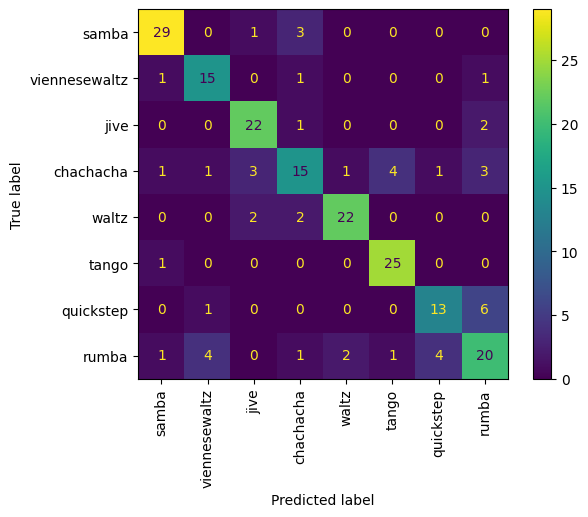

In [67]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnc = RadiusNeighborsClassifier(metric="cosine", radius=20)

loo = LeaveOneOut()
# k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(metric="cosine").fit(X=x_train, y=y_train)
# rnc = RadiusNeighborsClassifier(metric="cosine", radius=10).fit(X=x_train, y=y_train)

ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()

## GridSearch CV on Ballroom

In [ ]:
# Define a grid of parameters to search over
param_grid = {
    'n_mels': [50, 75, 100],      # Example values for n_mels
    'auto_cor_lag_seconds': [5, 8, 13],  # Example values for auto_cor_lag_seconds
    'stm_coefs' : [i for i in range(30, 400, 30)]
}

best_score = -1
best_params = None

# Iterate over all combinations of parameters
for n_mels in param_grid['n_mels']:
    for auto_cor_lag_seconds in param_grid['auto_cor_lag_seconds']:
        for stm_coefs in param_grid['stm_coefs']:
            print("n_mels:", n_mels, "auto_cor_lag_seconds:", auto_cor_lag_seconds, "stm_coefs:", stm_coefs)
            # Compute features with current parameters
            features = []
            labels = []
            for _, track in tqdm(ballroom_dataset.load_tracks().items()):
                y, sr = librosa.load(track.audio_path, sr=8000)
                features.append(helpers.compute_stm(y=y, sr=sr, win_size=160, hop=80, n_mels=n_mels, auto_cor_lag_seconds=auto_cor_lag_seconds)[:stm_coefs])
                labels.append(track.genre)

            # Encode labels
            encoded_labels = LabelEncoder().fit_transform(labels)

            # Initialize and evaluate the classifier
            knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
            loo = LeaveOneOut()
            cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
            mean_cv_score = cv_scores.mean()
            print("Mean CV Accuracy:", mean_cv_score)

            # Update best score and parameters if needed
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {
                    'n_mels': n_mels,
                    'auto_cor_lag_seconds': auto_cor_lag_seconds
                }

# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Mean CV Accuracy:", best_score)

## Greek/Cretan Dances


In [55]:
cretan_dances_data_path = Path("../datasets/CretanDances")

features = []
labels = []

for subfolder in cretan_dances_data_path.iterdir():
    if subfolder.is_dir():
        label = subfolder.name
        print(label)
        for audio_file in subfolder.glob("*.wav"):
            y, sr = librosa.load(audio_file, sr=None)
            # note that for this dataset, the number of coefs has been set to 30, as reported in the paper
            features.append(helpers.compute_stm(y=y, sr=sr, win_size=256, hop=128, auto_cor_lag_seconds=5, n_mels=50)[:90])
            labels.append(label)

encoded_labels = LabelEncoder().fit_transform(labels)

pentozalis
syrtos
sousta
maleviziotis
kalamatianos
kontilies


Cross-Validation Scores: [0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
Mean CV Accuracy: 0.6033519553072626


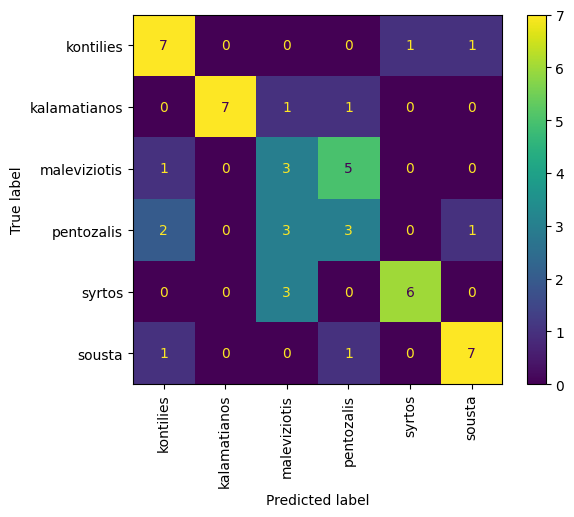

In [56]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

loo = LeaveOneOut()
# k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()

## GridSearch CV on GreekDances

In [ ]:
cretan_dances_data_path = Path("../datasets/CretanDances")

# Define a grid of parameters to search over
param_grid = {
    'n_mels': [50, 75, 100],      # Example values for n_mels
    'auto_cor_lag_seconds': [5, 8, 13],  # Example values for auto_cor_lag_seconds
    'stm_coefs' : [i for i in range(30, 400, 30)]
}

best_score = -1
best_params = None

# Iterate over all combinations of parameters
for n_mels in param_grid['n_mels']:
    for auto_cor_lag_seconds in param_grid['auto_cor_lag_seconds']:
        for stm_coefs in param_grid['stm_coefs']:
            print("n_mels:", n_mels, "auto_cor_lag_seconds:", auto_cor_lag_seconds, "stm_coefs:", stm_coefs)
            # Compute features with current parameters
            features = []
            labels = []
            for subfolder in cretan_dances_data_path.iterdir():
                if subfolder.is_dir():
                    label = subfolder.name
                    print(label)
                    for audio_file in subfolder.glob("*.wav"):
                        y, sr = librosa.load(audio_file, sr=8000)
                        features.append(helpers.compute_stm(y=y, sr=sr, win_size=160, hop=80, n_mels=n_mels, auto_cor_lag_seconds=auto_cor_lag_seconds)[:stm_coefs])
                        labels.append(label)


            # Encode labels
            encoded_labels = LabelEncoder().fit_transform(labels)

            # Initialize and evaluate the classifier
            knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
            loo = LeaveOneOut()
            cv_scores = cross_val_score(knn, features, labels, cv=loo, scoring="accuracy")
            mean_cv_score = cv_scores.mean()
            print("Mean CV Accuracy:", mean_cv_score)

            # Update best score and parameters if needed
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {
                    'n_mels': n_mels,
                    'auto_cor_lag_seconds': auto_cor_lag_seconds
                }

# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Mean CV Accuracy:", best_score)